# CIFAR-10

Trains a small CNN on the CIFAR-10 dataset and tracks multi-class accuracy.

## Dataset:
- CIFAR-10 contains 60,000 color images (32x32 pixels).
- 50,000 training images and 10,000 testing images.
- 10 classes: airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck.

## CNN Structure (122,570 weights):
1. Input: 32x32x3 (image size with RGB channels).
2. Conv2D: 32 filters, 3x3 kernel, ReLU activation.
3. MaxPooling2D: 2x2 pool size.
4. Conv2D: 64 filters, 3x3 kernel, ReLU activation.
5. MaxPooling2D: 2x2 pool size.
6. Conv2D: 64 filters, 3x3 kernel, ReLU activation.
7. Flatten layer.
8. Dense: 64 units, ReLU activation.
9. Dense: 10 units (softmax for classification).

## Steps:
1. Load and normalize CIFAR-10 dataset.
2. Train CNN with Adam optimizer and categorical crossentropy loss.
3. Track training and validation accuracy.
4. Test accuracy ~70% (varies with training).

### Convolution

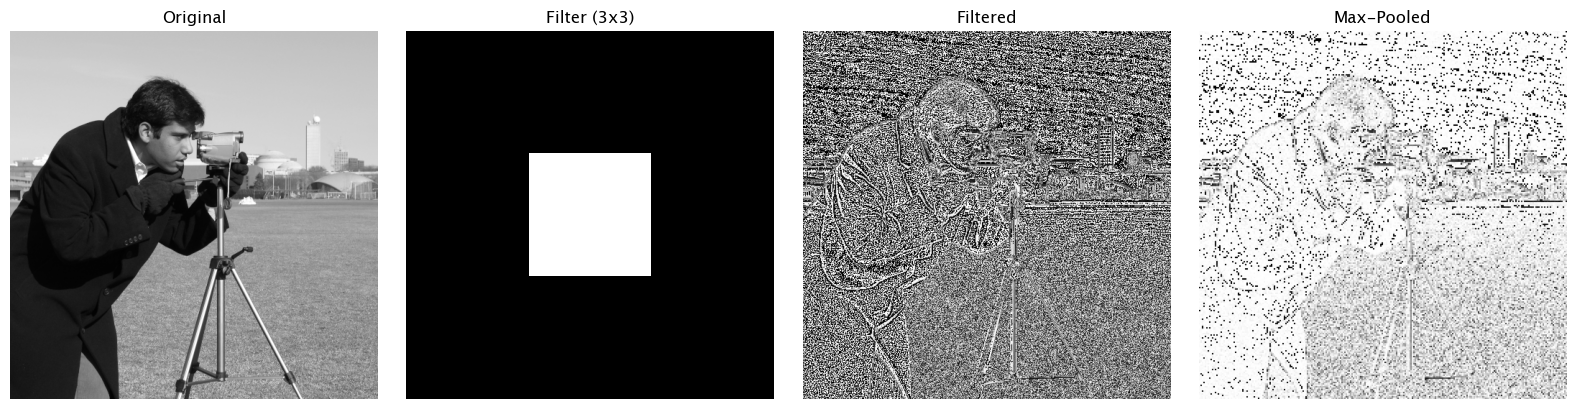

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import convolve
from skimage import data
from skimage.measure import block_reduce

# 1) Load a sample grayscale image
image = data.camera()  # (512, 512)

# 2) Define a small 3x3 filter
kernel = np.array([
    [-1, -1, -1],
    [-1,  8, -1],
    [-1, -1, -1]
], dtype=float)

# 3) Apply the filter via convolution
filtered = convolve(image, kernel, mode='reflect')

# 4) Apply 2x2 max pooling to the filtered image
pooled = block_reduce(filtered, block_size=(2, 2), func=np.max)

# 5) Create a 1x4 figure
fig, axes = plt.subplots(1, 4, figsize=(16, 4))

# Original image
axes[0].imshow(image, cmap='gray')
axes[0].set_title("Original")
axes[0].axis('off')

# Filter (kernel)
axes[1].imshow(kernel, cmap='gray')
axes[1].set_title("Filter (3x3)")
axes[1].axis('off')

# Filtered image
axes[2].imshow(filtered, cmap='gray')
axes[2].set_title("Filtered")
axes[2].axis('off')

# Max-pooled image
axes[3].imshow(pooled, cmap='gray')
axes[3].set_title("Max-Pooled")
axes[3].axis('off')

plt.tight_layout()
plt.show()


### OLS vs ANN vs CNN

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import numpy as np

# Load and preprocess the CIFAR-10 dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

# Normalize the image data to [0, 1]
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

# Flatten the images for linear and fully connected models
x_train_flat = x_train.reshape(x_train.shape[0], -1)
x_test_flat = x_test.reshape(x_test.shape[0], -1)

# One-hot encode the labels
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

# Linear model with Softmax
def create_linear_model_with_softmax(input_dim, num_classes):
    model = models.Sequential([
        layers.Dense(num_classes, input_shape=(input_dim,), activation='softmax')
    ])
    return model

# Fully Connected model
def create_fully_connected_model(input_dim, num_classes):
    model = models.Sequential([
        layers.Dense(512, input_shape=(input_dim,), activation='relu'),
        layers.Dense(256, activation='relu'),
        layers.Dense(num_classes, activation='softmax')
    ])
    return model

# Small CNN model
def create_cnn_model():
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.Flatten(),
        layers.Dense(64, activation='relu'),
        layers.Dense(10, activation='softmax')
    ])
    return model

# Train and evaluate a model
def train_and_evaluate_model(model, x_train, y_train, x_test, y_test, epochs=10, batch_size=64):
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    history = model.fit(x_train, y_train, epochs=epochs, 
                        validation_data=(x_test, y_test), 
                        batch_size=batch_size, verbose=2)
    return history

# Train and store the histories for all models
histories = {}
models_dict = {}

# Train Linear Model
linear_model = create_linear_model_with_softmax(x_train_flat.shape[1], 10)
histories['Linear'] = train_and_evaluate_model(linear_model, x_train_flat, y_train, x_test_flat, y_test)
models_dict['Linear'] = linear_model

# Train Fully Connected Model
fc_model = create_fully_connected_model(x_train_flat.shape[1], 10)
histories['Fully Connected'] = train_and_evaluate_model(fc_model, x_train_flat, y_train, x_test_flat, y_test)
models_dict['Fully Connected'] = fc_model

# Train CNN Model
cnn_model = create_cnn_model()
histories['CNN'] = train_and_evaluate_model(cnn_model, x_train, y_train, x_test, y_test)
models_dict['CNN'] = cnn_model

# Plot training and validation accuracy for all models
plt.figure(figsize=(10, 6))
for model_name, history in histories.items():
    plt.plot(history.history['accuracy'], label=f'{model_name} Train Accuracy')
    plt.plot(history.history['val_accuracy'], label=f'{model_name} Test Accuracy')

plt.title('Model Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()
import matplotlib.pyplot as plt
import numpy as np

def plot_model_predictions_grid(sample_images, sample_labels, models_dict, class_names):
    """
    Plots the true labels and model predictions in a 4x5 grid.
    
    Parameters:
    - sample_images: NumPy array of shape (num_images, 32, 32, 3)
    - sample_labels: NumPy array of shape (num_images, 10)
    - models_dict: Dictionary of trained models with keys as model names
    - class_names: List of class names corresponding to label indices
    """
    num_images = len(sample_images)
    num_models = len(models_dict)
    
    # Define the grid size: 4 rows (1 for true labels + 3 for models) x 5 columns
    fig, axes = plt.subplots(nrows=4, ncols=5, figsize=(20, 16))
    plt.subplots_adjust(hspace=0.4, wspace=0.3)
    
    # Row 1: True Labels
    for i in range(num_images):
        ax = axes[0, i]
        ax.imshow(sample_images[i])
        true_label = class_names[np.argmax(sample_labels[i])]
        ax.set_title(f"True: {true_label}", fontsize=12)
        ax.axis('off')
    
    # Rows 2-4: Model Predictions
    for row_idx, (model_name, model) in enumerate(models_dict.items(), start=1):
        for col_idx in range(num_images):
            ax = axes[row_idx, col_idx]
            image = sample_images[col_idx]
            label = sample_labels[col_idx]
            
            # Prepare input based on model type
            if model_name in ['Linear', 'Fully Connected']:
                input_image = image.reshape(1, -1)
            else:  # CNN
                input_image = np.expand_dims(image, axis=0)
            
            # Get prediction
            prediction = model.predict(input_image)
            predicted_class = class_names[np.argmax(prediction)]
            confidence = np.max(prediction)
            true_class = class_names[np.argmax(label)]
            
            # Determine if prediction is correct
            is_correct = predicted_class == true_class
            title_color = 'green' if is_correct else 'red'
            
            # Set title with prediction and confidence
            ax.set_title(f"{model_name}\nPred: {predicted_class}\nConf: {confidence:.2f}", 
                         color=title_color, fontsize=10)
            ax.imshow(image)
            ax.axis('off')
    
    # Add a main title
    plt.suptitle('CIFAR-10 Model Predictions', fontsize=20)
    plt.show()

# Example Usage:

# Define CIFAR-10 class names
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 
               'dog', 'frog', 'horse', 'ship', 'truck']

# Assume models_dict contains the trained models
# models_dict = {
#     'Linear': linear_model,
#     'Fully Connected': fc_model,
#     'CNN': cnn_model
# }

# Choose a few test images
num_to_display = 5
np.random.seed(42)  # For reproducibility
indices = np.random.choice(len(x_test), num_to_display, replace=False)
sample_images = x_test[indices]
sample_labels = y_test[indices]

# Plot predictions for all models in a 4x5 grid
plot_model_predictions_grid(sample_images, sample_labels, models_dict, class_names)

Epoch 1/10


/opt/homebrew/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


782/782 - 1s - 889us/step - accuracy: 0.3154 - loss: 1.9371 - val_accuracy: 0.3392 - val_loss: 1.8915
Epoch 2/10
782/782 - 0s - 616us/step - accuracy: 0.3597 - loss: 1.8441 - val_accuracy: 0.3395 - val_loss: 1.8615
Epoch 3/10
782/782 - 0s - 639us/step - accuracy: 0.3705 - loss: 1.8118 - val_accuracy: 0.3794 - val_loss: 1.7910
Epoch 4/10
782/782 - 1s - 666us/step - accuracy: 0.3751 - loss: 1.8005 - val_accuracy: 0.3542 - val_loss: 1.8305
Epoch 5/10
782/782 - 0s - 609us/step - accuracy: 0.3820 - loss: 1.7861 - val_accuracy: 0.3761 - val_loss: 1.7919
Epoch 6/10
782/782 - 0s - 598us/step - accuracy: 0.3850 - loss: 1.7780 - val_accuracy: 0.3762 - val_loss: 1.8070
Epoch 7/10
782/782 - 0s - 615us/step - accuracy: 0.3916 - loss: 1.7646 - val_accuracy: 0.3591 - val_loss: 1.8492
Epoch 8/10
782/782 - 0s - 594us/step - accuracy: 0.3889 - loss: 1.7763 - val_accuracy: 0.3385 - val_loss: 1.8980
Epoch 9/10
782/782 - 0s - 587us/step - accuracy: 0.3941 - loss: 1.7664 - val_accuracy: 0.3622 - val_loss: 1

/opt/homebrew/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


782/782 - 8s - 10ms/step - accuracy: 0.4226 - loss: 1.5864 - val_accuracy: 0.5240 - val_loss: 1.3167
Epoch 2/10
782/782 - 7s - 10ms/step - accuracy: 0.5593 - loss: 1.2337 - val_accuracy: 0.5956 - val_loss: 1.1389
Epoch 3/10
782/782 - 7s - 10ms/step - accuracy: 0.6165 - loss: 1.0835 - val_accuracy: 0.6243 - val_loss: 1.0903
Epoch 4/10
782/782 - 8s - 10ms/step - accuracy: 0.6562 - loss: 0.9805 - val_accuracy: 0.6614 - val_loss: 0.9676
Epoch 5/10


In [21]:
# Display model architecture
linear_model.summary()
fc_model.summary()
cnn_model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_8 (Dense)                 │ (None, 10)             │        30,730 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 92,192 (360.13 KB)

 Trainable params: 30,730 (120.04 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 61,462 (240.09 KB)

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_9 (Dense)                 │ (None, 512)            │     1,573,376 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,121,824 (19.54 MB)

 Trainable params: 1,707,274 (6.51 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 3,414,550 (13.03 MB)

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 30, 30, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 13, 13, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 4, 4, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 64)             │        65,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 367,712 (1.40 MB)

 Trainable params: 122,570 (478.79 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 245,142 (957.59 KB)

## Hinge vs Softmax Loss

/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


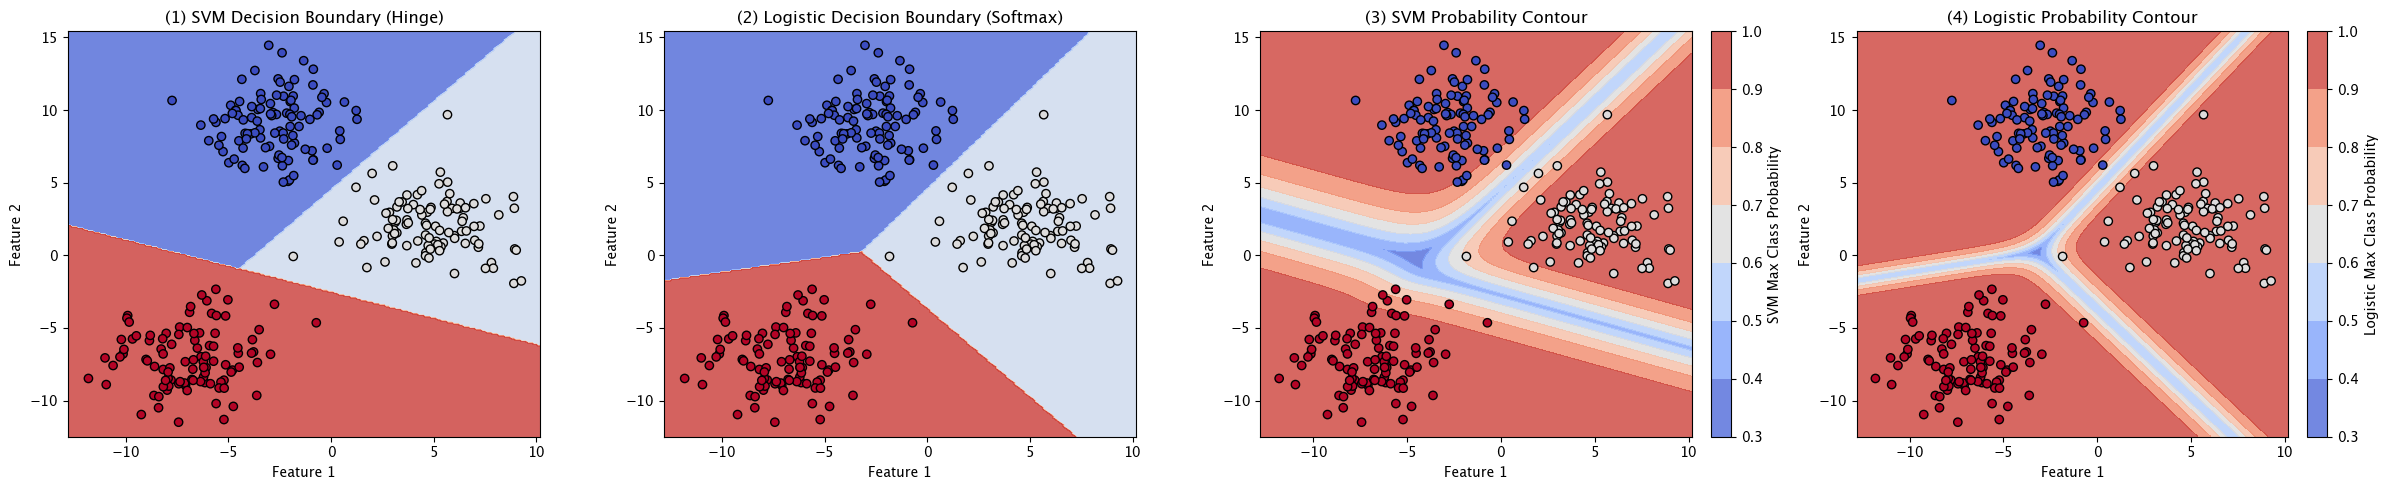

In [25]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

# Generate synthetic data (3 classes, moderate overlap)
X, y = make_blobs(n_samples=300, centers=3, random_state=42, cluster_std=2.0)

# Train multi-class SVM (Hinge Loss) with probability calibration (Platt scaling)
svm_model = SVC(kernel='linear', C=1.0, decision_function_shape='ovr', probability=True)
svm_model.fit(X, y)

# Train multi-class Logistic Regression (Softmax Loss)
softmax_model = LogisticRegression(multi_class='multinomial', solver='lbfgs')
softmax_model.fit(X, y)

# Create a 1x4 grid for plotting:
# (1) SVM Decision Boundary
# (2) Logistic Regression Decision Boundary
# (3) SVM Probability Contour
# (4) Logistic Regression Probability Contour
fig, axes = plt.subplots(1, 4, figsize=(24, 5))
titles = [
    "(1) SVM Decision Boundary (Hinge)",
    "(2) Logistic Decision Boundary (Softmax)",
    "(3) SVM Probability Contour",
    "(4) Logistic Probability Contour"
]

# Common meshgrid
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

# 1) Plot SVM decision boundary
Z_svm = svm_model.predict(np.c_[xx.ravel(), yy.ravel()])
Z_svm = Z_svm.reshape(xx.shape)
axes[0].contourf(xx, yy, Z_svm, alpha=0.8, cmap=plt.cm.coolwarm)
axes[0].scatter(X[:, 0], X[:, 1], c=y, edgecolor='k', cmap=plt.cm.coolwarm)
axes[0].set_title(titles[0])
axes[0].set_xlabel('Feature 1')
axes[0].set_ylabel('Feature 2')

# 2) Plot Logistic Regression decision boundary
Z_logistic = softmax_model.predict(np.c_[xx.ravel(), yy.ravel()])
Z_logistic = Z_logistic.reshape(xx.shape)
axes[1].contourf(xx, yy, Z_logistic, alpha=0.8, cmap=plt.cm.coolwarm)
axes[1].scatter(X[:, 0], X[:, 1], c=y, edgecolor='k', cmap=plt.cm.coolwarm)
axes[1].set_title(titles[1])
axes[1].set_xlabel('Feature 1')
axes[1].set_ylabel('Feature 2')

# 3) Plot SVM probabilities (Platt scaling) for the predicted class
probs_svm = svm_model.predict_proba(np.c_[xx.ravel(), yy.ravel()])
Z_svm_probs = np.max(probs_svm, axis=1)  # max probability among classes
Z_svm_probs = Z_svm_probs.reshape(xx.shape)
cont_svm = axes[2].contourf(xx, yy, Z_svm_probs, alpha=0.8, cmap=plt.cm.coolwarm)
axes[2].scatter(X[:, 0], X[:, 1], c=y, edgecolor='k', cmap=plt.cm.coolwarm)
axes[2].set_title(titles[2])
axes[2].set_xlabel('Feature 1')
axes[2].set_ylabel('Feature 2')
cbar_svm = fig.colorbar(cont_svm, ax=axes[2], fraction=0.046, pad=0.04)
cbar_svm.set_label('SVM Max Class Probability')

# 4) Plot Logistic Regression probabilities (Softmax) for the predicted class
probs_logistic = softmax_model.predict_proba(np.c_[xx.ravel(), yy.ravel()])
Z_log_probs = np.max(probs_logistic, axis=1)
Z_log_probs = Z_log_probs.reshape(xx.shape)
cont_log = axes[3].contourf(xx, yy, Z_log_probs, alpha=0.8, cmap=plt.cm.coolwarm)
axes[3].scatter(X[:, 0], X[:, 1], c=y, edgecolor='k', cmap=plt.cm.coolwarm)
axes[3].set_title(titles[3])
axes[3].set_xlabel('Feature 1')
axes[3].set_ylabel('Feature 2')
cbar_log = fig.colorbar(cont_log, ax=axes[3], fraction=0.046, pad=0.04)
cbar_log.set_label('Logistic Max Class Probability')

plt.tight_layout()
plt.show()


### Sigmoid vs ReLU vs ELU

Activation | Mean Grad   | Min Grad    | Max Grad    | Time (s)
Sigmoid | 0.005709 | -0.032324 | 1.105316 | 0.000962
ReLU | -0.000477 | -0.199949 | 0.025259 | 0.000436
ELU | -0.000196 | -0.148170 | 0.095274 | 0.001915


/var/folders/b7/1tvk5qmx0ds9c6gk2lrlhv380000gn/T/ipykernel_83665/1858695744.py:72: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(vals["grads"], label=name, shade=True, bw_method=0.2)
/var/folders/b7/1tvk5qmx0ds9c6gk2lrlhv380000gn/T/ipykernel_83665/1858695744.py:72: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(vals["grads"], label=name, shade=True, bw_method=0.2)
/var/folders/b7/1tvk5qmx0ds9c6gk2lrlhv380000gn/T/ipykernel_83665/1858695744.py:72: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(vals["grads"], label=name, shade=True, bw_method=0.2)


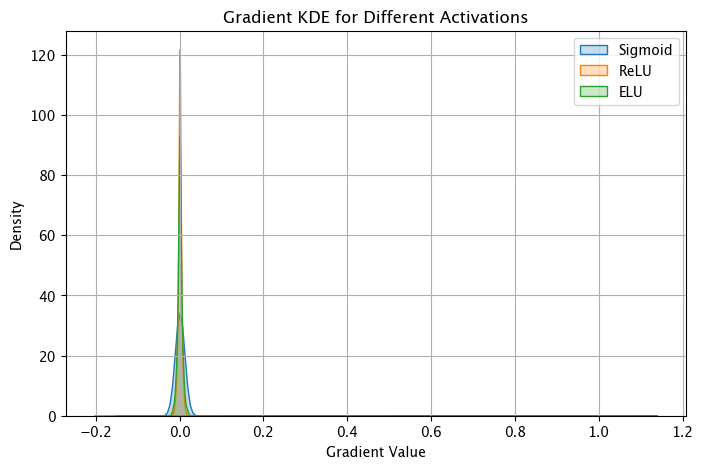

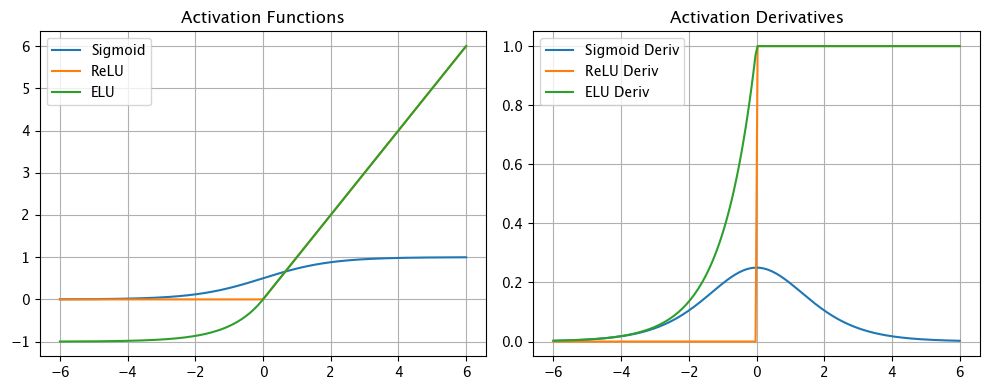

In [2]:
import time
import numpy as np
import torch
import torch.nn as nn
import seaborn as sns
import matplotlib.pyplot as plt

# ----- 1) Define Networks -----
class SimpleNet(nn.Module):
    def __init__(self, activation_fn, input_dim=100, hidden_dim=50):
        super(SimpleNet, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.act = activation_fn
        self.fc2 = nn.Linear(hidden_dim, 1)
    def forward(self, x):
        return self.fc2(self.act(self.fc1(x)))

# ----- 2) Activation Functions -----
activations = {
    "Sigmoid": nn.Sigmoid(),
    "ReLU": nn.ReLU(),
    "ELU": nn.ELU(alpha=1.0)
}

# ----- 3) Generate Random Data -----
torch.manual_seed(42)
N, input_dim = 1024, 100
X = torch.randn(N, input_dim)
y = torch.randn(N, 1)  # random regression target
criterion = nn.MSELoss()

# ----- 4) Compare Each Activation -----
results = {}
for name, act in activations.items():
    # Create model
    model = SimpleNet(act, input_dim=input_dim)
    optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
    
    start = time.time()
    # Forward
    pred = model(X)
    loss = criterion(pred, y)
    # Backward
    optimizer.zero_grad()
    loss.backward()
    total_time = time.time() - start
    
    # Collect gradient stats
    grads = []
    for p in model.parameters():
        if p.grad is not None:
            grads.append(p.grad.view(-1))
    grads = torch.cat(grads)
    
    results[name] = {
        "grads": grads.detach().numpy(),
        "mean_grad": grads.mean().item(),
        "min_grad": grads.min().item(),
        "max_grad": grads.max().item(),
        "time": total_time
    }

# ----- 5) Print Table of Results -----
print("Activation | Mean Grad   | Min Grad    | Max Grad    | Time (s)")
for name, vals in results.items():
    print("{} | {:.6f} | {:.6f} | {:.6f} | {:.6f}".format(
        name, vals["mean_grad"], vals["min_grad"], vals["max_grad"], vals["time"]))

# ----- 6) Plot Grad Distributions (KDE) -----
plt.figure(figsize=(8, 5))
for name, vals in results.items():
    sns.kdeplot(vals["grads"], label=name, shade=True, bw_method=0.2)
plt.title("Gradient KDE for Different Activations")
plt.xlabel("Gradient Value")
plt.ylabel("Density")
plt.legend()
plt.grid(True)
plt.show()

# ----- 7) (Optional) Plot Activation Functions & Derivatives -----
x_vals = np.linspace(-6, 6, 200)
sig = 1 / (1 + np.exp(-x_vals))
sig_prime = sig * (1 - sig)
relu = np.maximum(0, x_vals)
relu_prime = (x_vals > 0).astype(float)
elu = np.where(x_vals >= 0, x_vals, np.expm1(x_vals))
alpha = 1.0  # ELU alpha
elu_prime = np.where(x_vals >= 0, 1, alpha * np.exp(x_vals))

fig, axes = plt.subplots(1, 2, figsize=(10, 4))
axes[0].plot(x_vals, sig, label="Sigmoid")
axes[0].plot(x_vals, relu, label="ReLU")
axes[0].plot(x_vals, elu, label="ELU")
axes[0].set_title("Activation Functions")
axes[0].legend(); axes[0].grid(True)

axes[1].plot(x_vals, sig_prime, label="Sigmoid Deriv")
axes[1].plot(x_vals, relu_prime, label="ReLU Deriv")
axes[1].plot(x_vals, elu_prime, label="ELU Deriv")
axes[1].set_title("Activation Derivatives")
axes[1].legend(); axes[1].grid(True)

plt.tight_layout()
plt.show()


### Pre CNN Methods

Extracting SIFT features...
Extracting HOG features...
Combining SIFT and HOG features...
Training LightGBM...


/opt/homebrew/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Evaluating model...
Test Accuracy: 0.5864
              precision    recall  f1-score   support

    airplane       0.65      0.67      0.66      1000
  automobile       0.70      0.70      0.70      1000
        bird       0.51      0.45      0.47      1000
         cat       0.43      0.37      0.40      1000
        deer       0.48      0.51      0.50      1000
         dog       0.48      0.49      0.49      1000
        frog       0.60      0.66      0.63      1000
       horse       0.63      0.62      0.63      1000
        ship       0.67      0.67      0.67      1000
       truck       0.68      0.71      0.70      1000

    accuracy                           0.59     10000
   macro avg       0.58      0.59      0.58     10000
weighted avg       0.58      0.59      0.58     10000



/opt/homebrew/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


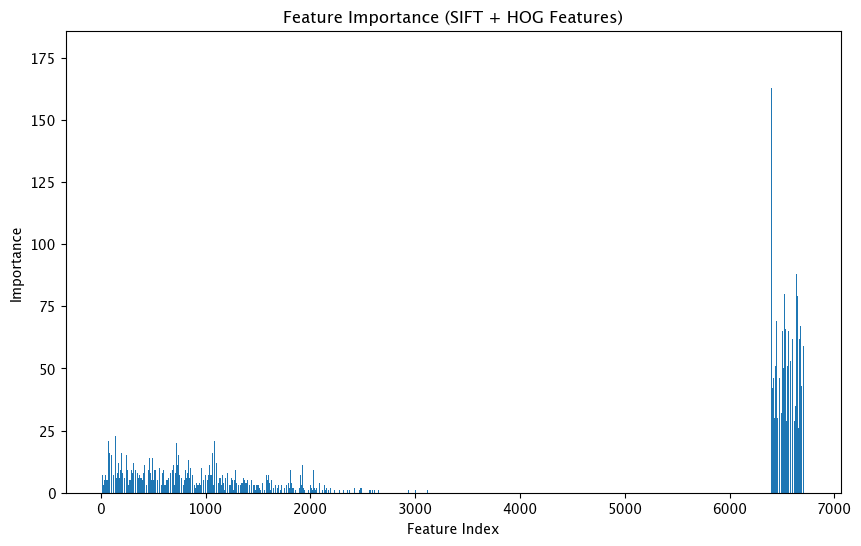

In [6]:
import cv2
import numpy as np
from skimage.feature import hog
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score, classification_report
from tensorflow.keras.datasets import cifar10
import matplotlib.pyplot as plt

# Load CIFAR-10 dataset
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Convert labels to 1D
y_train = y_train.flatten()
y_test = y_test.flatten()

# Extract SIFT features
def extract_sift_features(images, max_features=50):
    sift = cv2.SIFT_create(nfeatures=max_features)
    features = []
    for img in images:
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        _, desc = sift.detectAndCompute(gray, None)
        if desc is not None:
            flattened = desc.flatten()
            if len(flattened) > max_features * 128:
                flattened = flattened[:max_features * 128]
            else:
                flattened = np.pad(flattened, (0, max_features * 128 - len(flattened)))
        else:
            flattened = np.zeros(max_features * 128)
        features.append(flattened)
    return np.array(features)

# Extract HOG features
def extract_hog_features(images):
    features = []
    for img in images:
        gray = np.mean(img, axis=-1)
        hog_features = hog(
            gray,
            orientations=9,
            pixels_per_cell=(8, 8),
            cells_per_block=(2, 2),
            block_norm="L2-Hys",
            transform_sqrt=True,
        )
        features.append(hog_features)
    return np.array(features)

# Feature extraction
print("Extracting SIFT features...")
sift_train_features = extract_sift_features(x_train)
sift_test_features = extract_sift_features(x_test)

print("Extracting HOG features...")
hog_train_features = extract_hog_features(x_train)
hog_test_features = extract_hog_features(x_test)

# Combine SIFT and HOG features
print("Combining SIFT and HOG features...")
train_features = np.hstack([sift_train_features, hog_train_features])
test_features = np.hstack([sift_test_features, hog_test_features])

# Train LightGBM model
print("Training LightGBM...")
lgbm = LGBMClassifier(
    boosting_type='gbdt',
    objective='multiclass',
    num_class=10,
    n_estimators=100,
    learning_rate=0.1,
    random_state=42,
    verbose=-1  # Disable LightGBM training output
)
lgbm.fit(train_features, y_train)

# Evaluate the model
print("Evaluating model...")
y_pred = lgbm.predict(test_features)
accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy:.4f}")

# Classification report
print(classification_report(y_test, y_pred, target_names=[
    'airplane', 'automobile', 'bird', 'cat', 'deer', 
    'dog', 'frog', 'horse', 'ship', 'truck'
]))

# Feature importance visualization
plt.figure(figsize=(10, 6))
plt.bar(range(len(lgbm.feature_importances_)), lgbm.feature_importances_)
plt.title("Feature Importance (SIFT + HOG Features)")
plt.xlabel("Feature Index")
plt.ylabel("Importance")
plt.show()


In [2]:
pip install lightgbm

  Using cached lightgbm-4.5.0-py3-none-macosx_12_0_arm64.whl.metadata (17 kB)
Using cached lightgbm-4.5.0-py3-none-macosx_12_0_arm64.whl (1.6 MB)
Note: you may need to restart the kernel to use updated packages.
